# Estimating the SCC using CIL damage functions and the FAIR SCM

The experiment is conducted as follows:

* Use the RCP scenarios as defined by the default FAIR model
* Add an additional CO2 impulse (1 Gt C) to each trajectory in 2020 (updated from 2015)
* Compute damages using the resulting temperature trajectories
* Subtract the damages in the standard RCPs from the damages in the pulse runs
* Divide this value by the quantity of added CO2 (1 Gt C * 44.0098 / 12.011 = 3.66 Gt CO2) to achieve \$/ton CO2
* Compute the NPV of this time series of marginal damages using various discount rates

Note: Damage function units fed into this calculation should be billions of 2019 USD

## Set up workspace

In [2]:
import os
REPO = os.getenv('REPO')
OUTPUT = os.getenv('OUTPUT')
DATA = os.getenv('DATA')
LOG = os.getenv('LOG')

DB = OUTPUT
root =  f"{REPO}/energy-code-release-2020"

# Scenario options
# NOTE: set the following parameters according to your needs
model = 'main' # options are 'main', 'lininter', and 'lininter_double', 'lininter_half', 'mixed'
ssp = '5' # 2,3 or 4.Must by 3 if you are not running the main model 
hold_2100_damages_fixed = True # False or True 

# Toggle to generate plots or not
generate_plots = True

In [3]:
# import sys
# !conda install --yes --prefix {sys.prefix} matplotlib
%matplotlib inline

In [4]:
# SSP must be "3" unless you are running the main model, in which case it can be 
# also 2 or 4. This is just due to the scenarios we choose to put in the paper. 

if model == 'lininter' or model == 'lininter_double' or model == 'lininter_half':
    assert ssp == '3',"ssp must be 3 unless you are running the main model"


In [5]:
! pip install fair==1.3.2

In [6]:
import numpy as np
import pandas as pd
import xarray as xr
import os, glob

try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize'] = (16, 9)

from datetime import datetime

import sys
sys.path.append('./functions/.')
import load_fair

In [7]:
# !conda install --yes --prefix {sys.prefix} seaborn

In [8]:
# Assign price scenarios to run with

if ssp == '3':
    if model == 'lininter' or model == 'lininter_double' or model == 'lininter_half':
        # For lininter model:, or lininter_double or lininter_half model 
        scenario_to_run = 'price014' 
    else:
        # For main model
        scenario_to_run = 'price014', 'price0', 'price03', 'WITCHGLOBIOM42', 'MERGEETL60', 'REMINDMAgPIE1730', 'REMIND17CEMICS', 'REMIND17'
else:
    scenario_to_run = 'price014' 

    
if model == 'main':
    model_tag = ''
else:
    model_tag = '_{}'.format(model)
    
# run/code specifications
version = 'v0.5' # code version
specification = 'energy_SSP{}_all_prices'.format(ssp)
stem = 'df_mean_output_SSP{}{}'.format(ssp, model_tag) # file stem for df coefficients
MAGNITUDE_OF_DAMAGES = 1e9  # magnitude of damage function values

INPUT_path = '{}/projection_system_outputs/damage_function_estimation/coefficients/'.format(DB)
OUTPUT_path = '{}/figures/scc_values/{}/'.format(OUTPUT, model)

from pathlib import Path
Path( OUTPUT_path ).mkdir( parents=True, exist_ok=True )


# Load FAIR Temperatures Anomaly

## RCPs
We can run FAIR with the CO$_2$ emissions and non-CO$_2$ forcing from the four representative concentration pathway scenarios. To use the emissions-based version specify ```useMultigas=True``` in the call to ```fair_scm()```.

By default in multi-gas mode, volcanic and solar forcing plus natural emissions of methane and nitrous oxide are switched on.

## SCC

We can compute the SCC by adding an additional pulse in CO2 emissions to the RCP trajectory. 

### Scenario design
This study uses a 1 Gt C emissions pulse. You can change the pulse amount by modifying the PULSE_AMT variable below, and adapting the CONVERSION value to match.

In [9]:
PULSE_YEAR = 2020  # year in which pulse will be emitted
PULSE_AMT = 1.0  # in Gt C = 1e9 ton C

# CONVERSION is in units of [pulse/tCO2] = [1 pulse/PULSE_AMT GtC * 1 GtC/1e9 tC * 12tC/44tCO2]
# This is used to convert costs ($Bn / pulse) to SCC ($/ton CO2), but the $Bn to $ conversion is separate.
# Therefore, it should be the inverse of any changes to PULSE_AMT
CONVERSION = 1.0 / PULSE_AMT / 1e9 * 12.011 / 44.0098

In [10]:
# import importlib
# importlib.reload(load_fair)
fair_temperatures_anomaly = load_fair.temperatures_anomaly(PULSE_YEAR = PULSE_YEAR, 
                                                           PULSE_AMT = PULSE_AMT, 
                                                           make_plots = False, 
                                                           output = OUTPUT_path)

Finished loading FAIR


In [11]:
fair_temperatures_anomaly.sel(pulse = 'pulse',rcp = 'rcp45', year = 2050.0)

<xarray.DataArray ()>
array(0.85127034)
Coordinates:
    pulse    <U5 'pulse'
    rcp      <U5 'rcp45'
    year     float64 2.05e+03

In [12]:
fair_temperatures_anomaly

<xarray.DataArray (pulse: 2, rcp: 4, year: 736)>
array([[[-0.95778837, -0.95338406, -0.94886962, ..., -0.07146356,
         -0.07311725, -0.07477025],
        [-0.95790237, -0.95349806, -0.94898362, ...,  2.23953803,
          2.2407636 ,  2.24199016],
        [-0.95632565, -0.95192134, -0.9474069 , ...,  3.63819565,
          3.64002373,  3.64184667],
        [-0.9608241 , -0.95641979, -0.95190535, ...,  8.45236132,
          8.45608114,  8.45978626]],

       [[-0.95778837, -0.95338406, -0.94886962, ..., -0.06986345,
         -0.07151809, -0.07317205],
        [-0.95790237, -0.95349806, -0.94898362, ...,  2.24117657,
          2.24240237,  2.24362915],
        [-0.95632565, -0.95192134, -0.9474069 , ...,  3.63972485,
          3.64155319,  3.64337639],
        [-0.9608241 , -0.95641979, -0.95190535, ...,  8.45302899,
          8.45674844,  8.46045319]]])
Coordinates:
  * pulse    (pulse) <U5 'rcp' 'pulse'
  * rcp      (rcp) <U5 'rcp26' 'rcp45' 'rcp60' 'rcp85'
  * year     (year) float64 1.765e+03 1.766e+03 1.767e+03 ... 2.499e+03 2.5e+03

## Incorporate a single damage function

This is the damage function from Tamma, with a set of coefficients for each year.

Version 0.3 update: The damage function can now be held constant or allowed to vary post-2100. Additionally, different valuation scenarios can be selected within the damage function .csv file. See comments in the document header. 

Note: damages are estimated in Billion 2005 \$PPP, so use the U.S. GDP deflator for 2005 from the World Bank. Take the ratio with the `PULSE_YEAR` deflator (U.S. GDP deflator for the pulse_year from the World Bank) to convert the dollars from 2005 \$PPP to `PULSE_YEAR` $PPP. Update - in version 0.5, the damages are input as billions of 2019 dollars, so these conversion factors are just set to one. 

In [13]:
# Time the SCC calculation
startTime = datetime.now()

# Make sure the 'year', 'placeholder' and 'growth_rate' columns are the first three columns in the damage function .csv
fps = glob.glob('{}/{}.csv'.format(INPUT_path,stem))

def read_damage_func(fp):
    df = pd.read_csv(fp, index_col=[0,1,2])
    df.columns.names = ['coeff']
    return df.stack('coeff').to_xarray()

ss = len(stem) + 1
ee = ss + 4

ds = xr.Dataset({
    os.path.splitext(os.path.basename(fp))[0]: read_damage_func(fp) for fp in fps
})

In [14]:
ds

<xarray.Dataset>
Dimensions:              (year: 286, placeholder: 1, growth_rate: 1, coeff: 5)
Coordinates:
  * year                 (year) int64 2015 2016 2017 2018 ... 2298 2299 2300
  * placeholder          (placeholder) object 'ss'
  * growth_rate          (growth_rate) object 'price014'
  * coeff                (coeff) object 'cons' 'beta1' ... 'anomalymax'
Data variables:
    df_mean_output_SSP5  (year, placeholder, growth_rate, coeff) float64 -0.6...

In [15]:
# The placeholder dimension is not used. The line .sel(placeholder='ss') will get rid of it. (if its in there, change this)
coeffs_all_years = (
    ds.sel(placeholder='ss')
    .to_array(dim='variable').to_series().unstack('year')
    .reindex(list(range(2020, 2301)), axis=1)
    .stack('year')
    .unstack('coeff')
    .to_xarray()
)

# The following operation reorders the 'variable' and 'year' coordinates. This causes errors when plotting.
# I can't get it to not do that here, but I fix it when damages are calculated below with a transpose() call.
if hold_2100_damages_fixed:
    mask = coeffs_all_years['year'] > 2100
    coeffs_2100 = coeffs_all_years.sel(year=2100)
    coeffs_all_years = xr.where(mask, coeffs_2100, coeffs_all_years)

In [16]:
coeffs_all_years = coeffs_all_years.sel(variable=stem)

In [17]:
# debugging
df = coeffs_all_years.to_dataframe().reset_index()
df = df[df.growth_rate == "price014"]


In [18]:
df[df.year < 2105]

,year,growth_rate,cons,beta1,beta2,anomalymin,anomalymax,variable
0,2020,price014,4.453563,-93.34052,12.46415,0.199384,0.635795,df_mean_output_SSP5
1,2021,price014,26.910550,-189.97430,108.51940,0.207176,0.685785,df_mean_output_SSP5
2,2022,price014,24.935040,-184.98150,101.01180,0.233061,0.719394,df_mean_output_SSP5
3,2023,price014,17.872930,-151.76120,59.16871,0.259854,0.758828,df_mean_output_SSP5
4,2024,price014,18.336110,-155.50610,58.44685,0.280028,0.804695,df_mean_output_SSP5
...,...,...,...,...,...,...,...,...
80,2100,price014,-205.018300,-76.39588,10.98351,0.000000,11.000000,df_mean_output_SSP5
81,2101,price014,-205.018300,-76.39588,10.98351,0.000000,11.000000,df_mean_output_SSP5
82,2102,price014,-205.018300,-76.39588,10.98351,0.000000,11.000000,df_mean_output_SSP5
83,2103,price014,-205.018300,-76.39588,10.98351,0.000000,11.000000,df_mean_output_SSP5


/Users/ruixueli/opt/miniconda3/envs/energy_env_py3/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


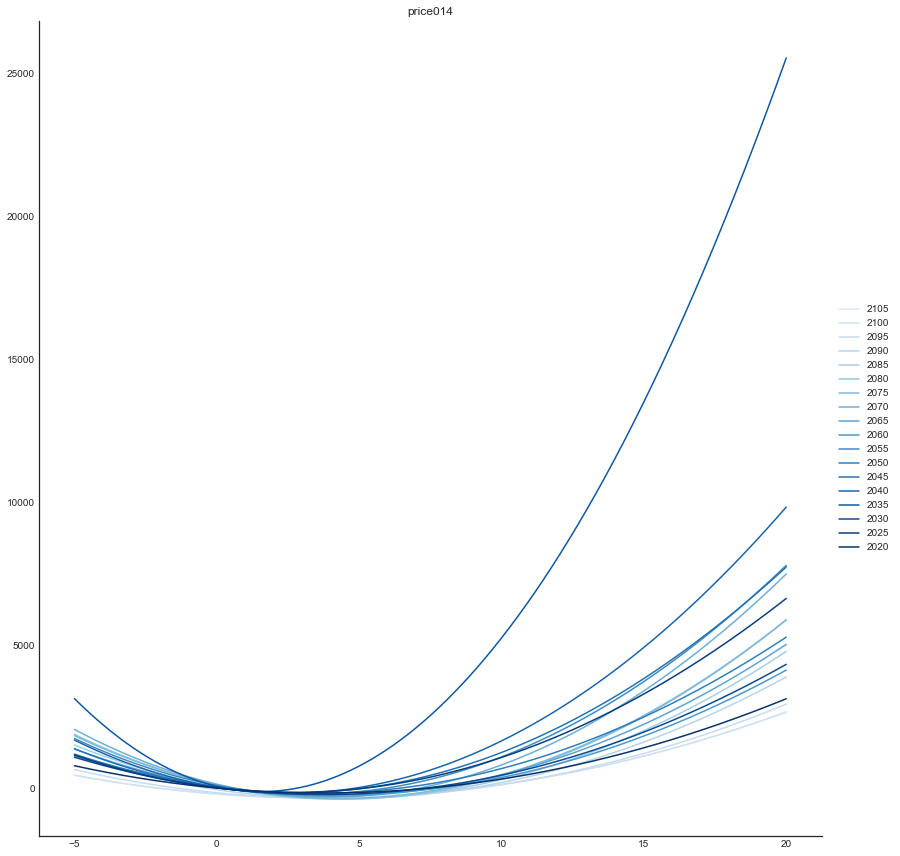

In [19]:
powers = xr.DataArray(
        np.arange(0, 11),
        dims=['coeff'],
        coords=[['cons'] + ['beta{}'.format(i) for i in range(1, 11)]])

if generate_plots:
    temps = np.linspace(-5, 20, 1101)
    temps = xr.DataArray(temps, dims=['temp'], coords=[temps])

    numvars = len(coeffs_all_years.growth_rate)
    fig, axes = plt.subplots((numvars+1)//2, min(2, numvars), figsize=(15, 15))

    if numvars == 1:
        axes = np.array([[axes]])

    # dot product of coeffs and powers of temp
    spaghetti = (
        (coeffs_all_years.to_array('coeff') * (temps ** powers)).sum(dim='coeff'))

    for vi, v in enumerate(coeffs_all_years.growth_rate.values):

        lines = []
        for y in reversed(coeffs_all_years.year.values[:86:5]):

            lines.append(
                axes[vi//2, vi%2].plot(
                    temps.values,
                    spaghetti.sel(year=y, growth_rate=v).values,
                    color=matplotlib.cm.Blues_r((y-2020.0)/(2100-2000)),
                    label=int(y)))

        axes[vi//2, vi%2].set_facecolor('white')
        axes[vi//2, vi%2].set_title(v)

    plt.subplots_adjust(right=0.85)
    axes[0, -1].legend(
        list(reversed(lines))[::5],
        labels=list(reversed(coeffs_all_years.year.values[:86]))[::5],
        loc='center left',
        bbox_to_anchor=(1.01, (1-(((numvars-1)//2)%2))*0.5))
    fig.set_facecolor('white')

    sns.despine()
    

### Compute damages

Combine the damage function coefficients with the FAIR temperatures:

$$d_y = c_2*T_y^2+C_1*T_y+C_0 \hspace{1in}\forall \hspace{0.1in} y \in [2020, 2300]$$

In [20]:
damages = (
    (coeffs_all_years.to_array('coeff') * (fair_temperatures_anomaly ** powers)).sum(dim='coeff'))

In [21]:
damages.pulse.values

array(['rcp', 'pulse'], dtype='<U5')

### Plot time series of damages

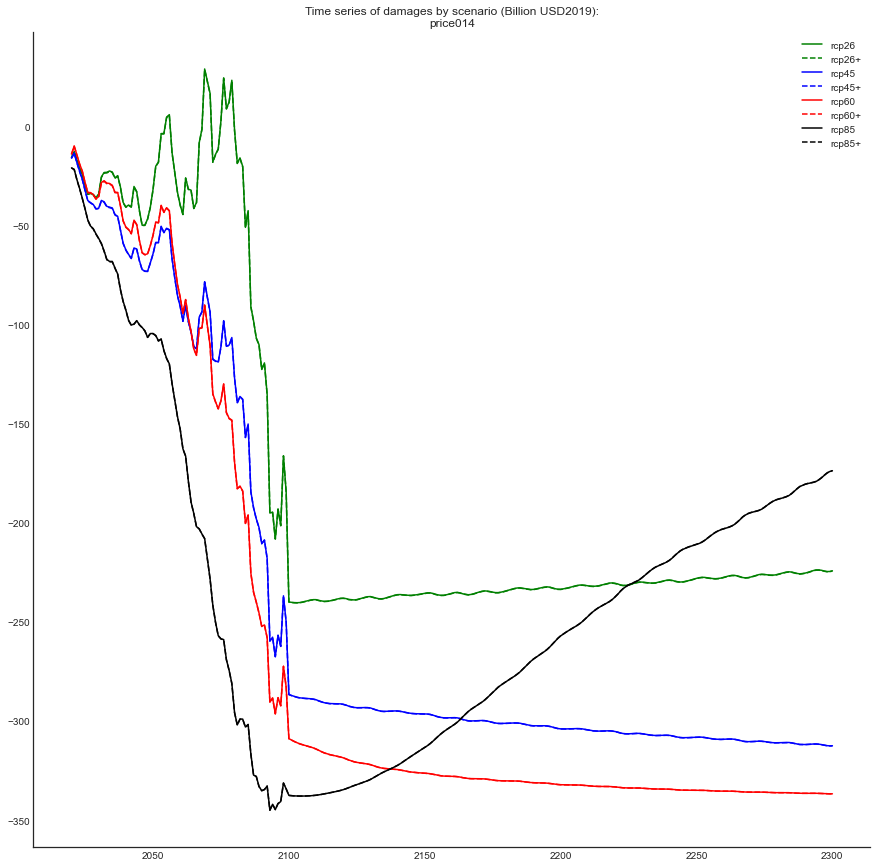

In [22]:
if generate_plots:
    numvars = len(coeffs_all_years.growth_rate)
    fig, ax = plt.subplots((numvars+1)//2, min(2, numvars), figsize=(15, 15))

    if numvars == 1:
        ax = np.array([[ax]])

    colors = ['green', 'blue', 'red', 'black']
    styles = ['solid', 'dashed']

    lines = []
    labels = []
    for g, gr in enumerate(damages.growth_rate.values):
        for r, rcp in enumerate(damages.rcp.values):
            for p, pulse in enumerate(damages.pulse.values):
                if(g==0):
                    labels.append('{}{}'.format(rcp, ['', '+'][p]))
                lines.append(
                    ax[g//2, g%2].plot(
                        damages.year,
                        damages.sel(growth_rate=gr, rcp=rcp, pulse=pulse),
                        color=colors[r],
                        linestyle=styles[p])[0])
        
        ax[g//2, g%2].set_title('Time series of damages by scenario (Billion USD2019):\n{}'.format(gr))
        ax[g//2, g%2].legend(lines, labels)

    sns.despine()    

In [23]:
damages['growth_rate'].values

array(['price014'], dtype=object)

### Plot time series of damages incurred due to pulse

<xarray.DataArray (year: 281, pulse: 1, rcp: 4)>
array([[[-0.01432897, -0.0143449 , -0.01450542, -0.01393891]],

       [[-0.03692091, -0.03661244, -0.03829396, -0.032529  ]],

       [[-0.04424911, -0.04360029, -0.04576301, -0.03836888]],

       ...,

       [[-0.03161333, -0.01419469, -0.00280191,  0.01731291]],

       [[-0.03162642, -0.01416952, -0.00276319,  0.01734576]],

       [[-0.03168675, -0.01418926, -0.00276586,  0.01735684]]])
Coordinates:
  * year         (year) float64 2.02e+03 2.021e+03 ... 2.299e+03 2.3e+03
    variable     <U19 'df_mean_output_SSP5'
    growth_rate  <U8 'price014'
  * pulse        (pulse) <U5 'pulse'
  * rcp          (rcp) <U5 'rcp26' 'rcp45' 'rcp60' 'rcp85'


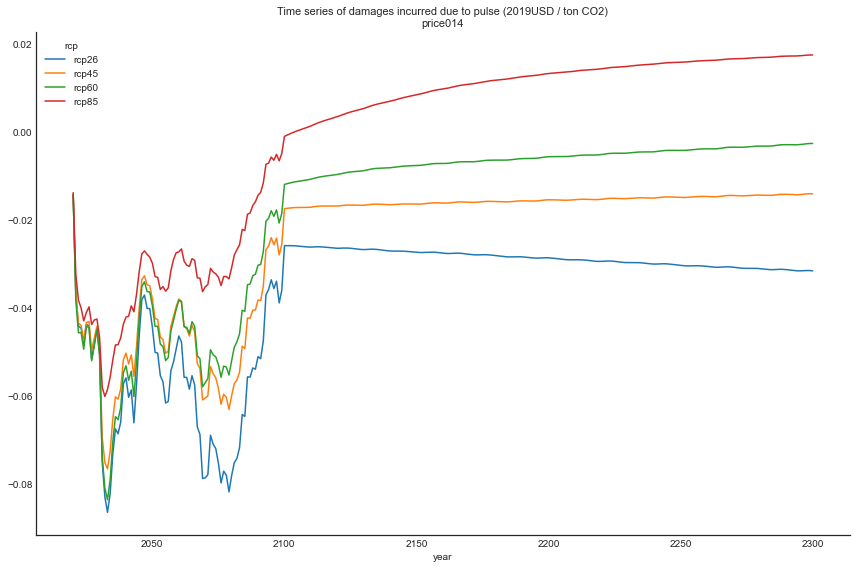

In [24]:
if generate_plots:
    fig, axes = plt.subplots((numvars+1)//2, min(2, numvars), figsize=(12, 8))

    if numvars == 1:
        axes = np.array([[axes]])

    for vi, var in enumerate(damages['growth_rate'].values):
        (damages.sel(growth_rate=var) * MAGNITUDE_OF_DAMAGES * CONVERSION).diff(dim='pulse').sel(pulse='pulse').plot.line(x='year', ax=axes[vi//2, vi%2])
        axes[vi//2, vi%2].axes.set_title(
            'Time series of damages incurred due to pulse (2019USD / ton CO2)\n{}'.format(var),
            size=11)
        print((damages.sel(growth_rate=var) * MAGNITUDE_OF_DAMAGES * CONVERSION).diff(dim='pulse'))

    sns.despine()
    plt.tight_layout()


### Compue the SCC (NPV of damages)

discount the time series of damages using the formula

$$SCC=\sum_{y\in\left[2020, 2300\right]}{\frac{d_y}{\left({1+r}\right)^{y-2020}}}$$

### Plot the current equivalent damage time series

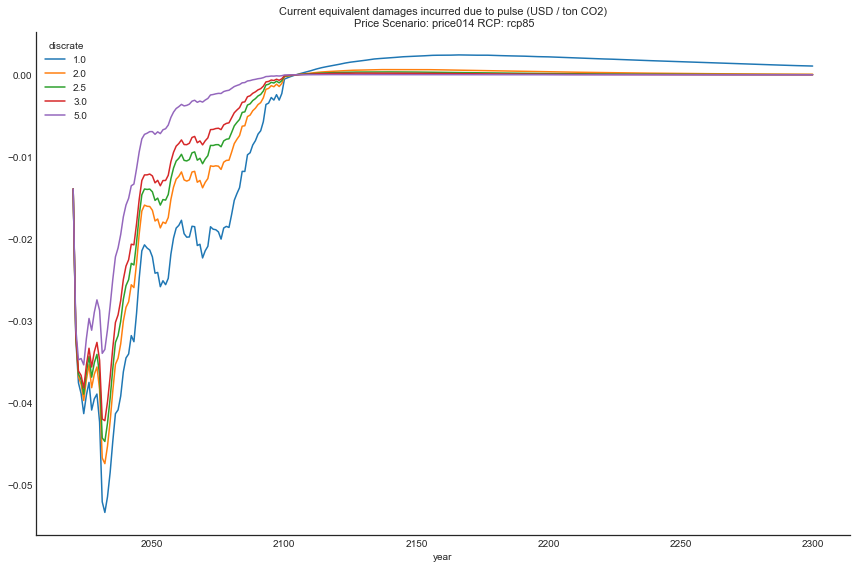

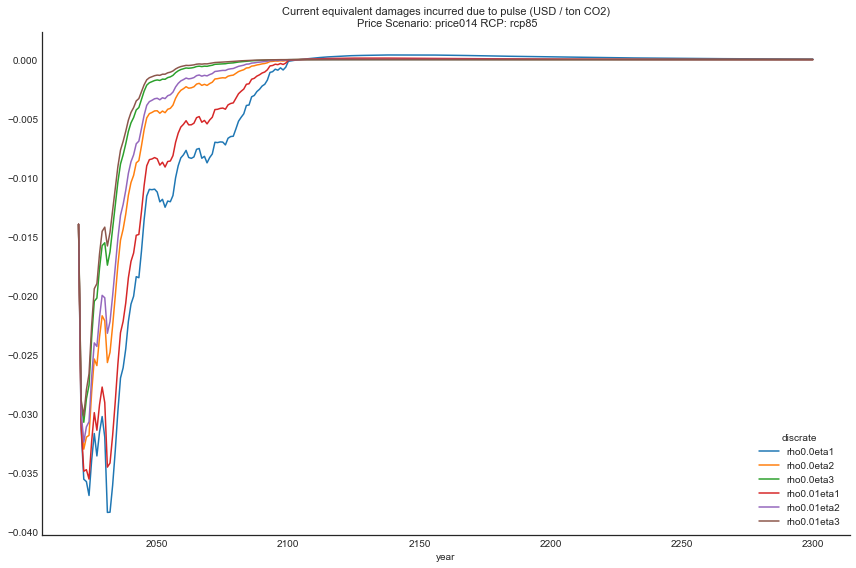

In [25]:
discrates_simple = [1.,2.,2.5, 3., 5.]


discdata = []
for r in discrates_simple:
    discdata.append(damages / (1+r/100)**(damages.year - 2020)) #updated in version 0.5 to 2020

discfac_ramsey = pd.read_csv(f"{DATA}/reference/ramsey_factors_energy.csv".format(root))
discfac_ramsey = discfac_ramsey.loc[discfac_ramsey.ssp == "SSP"+ssp] 
discfac_ramsey["discrates"] = "rho" + discfac_ramsey.rho.astype(str) + "eta" + discfac_ramsey.eta.astype(str)
discfac_ramsey = discfac_ramsey.loc[(discfac_ramsey.year >= 2020) &( discfac_ramsey.ssp == "SSP"+ssp)]
discrates_ramsey = discfac_ramsey.discrates.unique()
discfac_ramsey[stem] = discfac_ramsey.discount_factor
discfac_ramsey = discfac_ramsey[["year",stem,"discrates"]]
discfac_ramsey = discfac_ramsey.set_index(["year",'discrates']).to_xarray().to_array()

for r in discrates_ramsey:
    discdata.append((damages * discfac_ramsey.sel(discrates=r)).squeeze(
        dim = ["variable"]).drop(labels = "discrates"))

discrates_ramsey = discrates_ramsey.tolist()
discrates = discrates_simple + discrates_ramsey

current_equivalent_damages = xr.concat(discdata, dim=pd.Index(discrates, name='discrate'))

current_equivalent_damages_simple = current_equivalent_damages.sel(discrate = discrates_simple)
current_equivalent_damages_ramsey = current_equivalent_damages.sel(discrate = discrates_ramsey)

rcp = 'rcp85'
if generate_plots: 
    fig, axes = plt.subplots((numvars+1)//2, min(2, numvars), figsize=(12, 8))

    if numvars == 1:
        axes = np.array([[axes]])

    for vi, var in enumerate(damages['growth_rate'].values):
        (current_equivalent_damages_simple.sel(growth_rate=var, rcp=rcp) * MAGNITUDE_OF_DAMAGES * CONVERSION).diff(dim='pulse').sel(pulse='pulse').plot.line(x='year', ax=axes[vi//2, vi%2])
        axes[vi//2, vi%2].axes.set_title(
            'Current equivalent damages incurred due to pulse (USD / ton CO2)\n Price Scenario: {} RCP: {}'.format(var, rcp),
            size=11)

    sns.despine()
    plt.tight_layout()
    plt.savefig('{}/figures/SSP{}_fixed_{}_{}_current_equivalent_damages_rcp85_simple_discrates.pdf'.format(OUTPUT,ssp,hold_2100_damages_fixed, model))

    
    
if generate_plots: 
    fig, axes = plt.subplots((numvars+1)//2, min(2, numvars), figsize=(12, 8))

    if numvars == 1:
        axes = np.array([[axes]])

    for vi, var in enumerate(damages['growth_rate'].values):
        (current_equivalent_damages_ramsey.sel(growth_rate=var, rcp=rcp) * MAGNITUDE_OF_DAMAGES * CONVERSION).diff(dim='pulse').sel(pulse='pulse').plot.line(x='year', ax=axes[vi//2, vi%2])
        axes[vi//2, vi%2].axes.set_title(
            'Current equivalent damages incurred due to pulse (USD / ton CO2)\n Price Scenario: {} RCP: {}'.format(var, rcp),
            size=11)

    sns.despine()
    plt.tight_layout()
    plt.savefig('{}/figures/SSP{}_fixed_{}_{}_current_equivalent_damages_rcp85_ramsey_discrates.pdf'.format(OUTPUT,ssp,hold_2100_damages_fixed, model))

    
    


In [26]:
discrates_ramsey

['rho0.0eta1',
 'rho0.0eta2',
 'rho0.0eta3',
 'rho0.01eta1',
 'rho0.01eta2',
 'rho0.01eta3']

In [27]:
# WIP: update figure 4 panel D
# discrates = [2.]

# discdata = []
# for r in discrates:
#     discdata.append(damages / (1+r/100)**(damages.year - 2020)) #updated in version 0.5 to 2020

# current_equivalent_damages = xr.concat(discdata, dim=pd.Index(discrates, name='discrate'))

# rcp = 'rcp45'
# if generate_plots: 
#     fig, axes = plt.subplots((numvars+1)//2, min(2, numvars), figsize=(12, 8))

#     if numvars == 1:
#         axes = np.array([[axes]])

#     for vi, var in enumerate(damages['growth_rate'].values):
#         (current_equivalent_damages.sel(growth_rate=var, rcp=rcp) * MAGNITUDE_OF_DAMAGES * CONVERSION).diff(dim='pulse').sel(pulse='pulse').plot.line(x='year', ax=axes[vi//2, vi%2])
#         axes[vi//2, vi%2].axes.set_title(
#             'Current equivalent damages incurred due to pulse (USD / ton CO2)\n Price Scenario: {} RCP: {}'.format(var, rcp),
#             size=11)

#     sns.despine()
#     plt.tight_layout()
#     plt.savefig('{}/figures/SSP{}_fixed_{}_current_equivalent_damages_rcp45.pdf'.format(root,ssp,hold_2100_damages_fixed))


### Plot SCC (sum of discounted marginal damage time series) by discount rate and RCP

In [28]:
scc = (
    (current_equivalent_damages.diff(dim='pulse').sel(pulse='pulse') * MAGNITUDE_OF_DAMAGES * CONVERSION)
    .sum(dim='year'))

scc_pre_2100 = (
    (current_equivalent_damages.sel(year=slice(2020, 2099)).diff(dim='pulse')
    .sel(pulse='pulse') * MAGNITUDE_OF_DAMAGES * CONVERSION)
    .sum(dim='year'))

scc_post_2100 = (
    (current_equivalent_damages.sel(year=slice(2100, 3000)).diff(dim='pulse')
    .sel(pulse='pulse') * MAGNITUDE_OF_DAMAGES * CONVERSION)
    .sum(dim='year'))

scc_share_post2100 = (
    scc_post_2100 / scc)

scc = xr.concat([scc, scc_pre_2100, scc_post_2100, scc_share_post2100], pd.Index(['all', 'pre2100', 'post2100', 'share_post2100'], name='time_cut'))


### Export SCC to CSV

In [29]:
 (
    scc
    .to_series()
    .unstack('rcp')
    .to_csv('{}/scc_{}_2100-fixed-{}.csv'.format(OUTPUT_path, specification, hold_2100_damages_fixed)))

In [30]:
'{}/scc_{}_2100-fixed-{}.csv'.format(OUTPUT_path, specification, hold_2100_damages_fixed)

'//Users/ruixueli/Downloads/energy_data_release/OUTPUT/figures/scc_values/main//scc_energy_SSP5_all_prices_2100-fixed-True.csv'

In [31]:
# Print the output to the notebook, so we can take a look in the browser.
scc.to_series().unstack('rcp')

rcp                                        rcp26     rcp45     rcp60     rcp85
time_cut       discrate    growth_rate                                        
all            1.0         price014    -4.250066 -3.288295 -2.919035 -1.522414
               2.0         price014    -2.558814 -2.123439 -2.052994 -1.373934
               2.5         price014    -2.124980 -1.799773 -1.778133 -1.250819
               3.0         price014    -1.811613 -1.558373 -1.562853 -1.135537
               5.0         price014    -1.117356 -0.999481 -1.032358 -0.799466
               rho0.0eta1  price014    -1.830229 -1.543965 -1.512250 -1.047638
               rho0.0eta2  price014    -0.833222 -0.751129 -0.774768 -0.605816
               rho0.0eta3  price014    -0.508467 -0.473075 -0.493605 -0.402193
               rho0.01eta1 price014    -1.345395 -1.173722 -1.186695 -0.882103
               rho0.01eta2 price014    -0.703815 -0.642967 -0.667803 -0.531690
               rho0.01eta3 price014    -0.455659 -0.426873 -0.446055 -0.366500
pre2100        1.0         price014    -3.149813 -2.650765 -2.622848 -1.866056
               2.0         price014    -2.278910 -1.953667 -1.965164 -1.439577
               2.5         price014    -1.972258 -1.705672 -1.727621 -1.281909
               3.0         price014    -1.725129 -1.504435 -1.533050 -1.150910
               5.0         price014    -1.106127 -0.992282 -1.028091 -0.800706
               rho0.0eta1  price014    -1.658796 -1.439955 -1.458405 -1.087749
               rho0.0eta2  price014    -0.821633 -0.743777 -0.770530 -0.607414
               rho0.0eta3  price014    -0.507371 -0.472367 -0.493176 -0.402291
               rho0.01eta1 price014    -1.292115 -1.140487 -1.168324 -0.891553
               rho0.01eta2 price014    -0.699441 -0.640162 -0.666140 -0.532172
               rho0.01eta3 price014    -0.455207 -0.426579 -0.445874 -0.366533
post2100       1.0         price014    -1.100254 -0.637530 -0.296187  0.343642
               2.0         price014    -0.279904 -0.169771 -0.087831  0.065643
               2.5         price014    -0.152722 -0.094100 -0.050513  0.031090
               3.0         price014    -0.086484 -0.053938 -0.029804  0.015373
               5.0         price014    -0.011229 -0.007199 -0.004266  0.001240
               rho0.0eta1  price014    -0.171433 -0.104010 -0.053846  0.040111
               rho0.0eta2  price014    -0.011589 -0.007352 -0.004238  0.001598
               rho0.0eta3  price014    -0.001096 -0.000708 -0.000428  0.000098
               rho0.01eta1 price014    -0.053280 -0.033235 -0.018372  0.009451
               rho0.01eta2 price014    -0.004374 -0.002805 -0.001663  0.000482
               rho0.01eta3 price014    -0.000452 -0.000294 -0.000181  0.000033
share_post2100 1.0         price014     0.258879  0.193879  0.101467 -0.225721
               2.0         price014     0.109388  0.079951  0.042782 -0.047777
               2.5         price014     0.071870  0.052285  0.028408 -0.024855
               3.0         price014     0.047739  0.034612  0.019070 -0.013538
               5.0         price014     0.010049  0.007203  0.004133 -0.001552
               rho0.0eta1  price014     0.093668  0.067366  0.035606 -0.038287
               rho0.0eta2  price014     0.013909  0.009788  0.005470 -0.002637
               rho0.0eta3  price014     0.002155  0.001497  0.000868 -0.000244
               rho0.01eta1 price014     0.039602  0.028316  0.015481 -0.010714
               rho0.01eta2 price014     0.006215  0.004362  0.002490 -0.000906
               rho0.01eta3 price014     0.000992  0.000688  0.000405 -0.000091